# Transport Properties

Electrical conductivities can be computed within the self-energy relaxation-time approximation (SERTA) and the constant relaxation-time approximation approximation (CRTA) using DFTBephy v.0.1.Carrier densities are also computed, and mobilities can be obtained in post-processing using [`Graphene-Mobility.ipynb`](https://github.com/CoMeT4MatSci/dftbephy/blob/master/notebooks/Graphene-Mobility.ipynb).  

In this example, the electrical conductivity is calculated using a chemical potential range from 0 to 0.40 eV at room temperature. 


The `Conductivities={}` block in the input file is as follows:

```
    Conductivities = SERTA {
        kpoints = Mesh {
            npoints = 400 400 1
            shift = -0.64566667 -0.32283333 0.0
            refinement = 20
        }
        ############## only for SERTA ###########
        qpoints = Mesh {
            npoints = 200 200 1
            refinement = 10
        }
        #########################################

        Efermi [eV] = -4.6585
        bands = 3 4
        mu [eV] = Range { 0.0 0.40 40 }
        temperature [eV] = 0.0259

        sigma [eV] = 0.003
        # Ecut is relative to Efermi
        Ecut [eV] = 1.0
        SpinDegeneracy = 2
    }
```  

Conductivity calculations can be performed with the [`dftbephy-mobility-mpi.py`](https://github.com/CoMeT4MatSci/dftbephy/blob/master/scripts/dftbephy-mobility-mpi.py) script. 

```
mpirun -np 24 python dftbephy-mobility-mpi.py |& tee -a run-conductivity.log
```

The calcuated trasnport properties will be saved in `transport-mu-mpi.json` file.
This notebook presents an electronic transport analysis for graphene. 

In [1]:
import os

import matplotlib.pyplot as plt

import json

import numpy as np
from scipy.integrate import quad

from BoltzTraP2.fd import FD, dFDde
from BoltzTraP2 import units

In [2]:
basedir='./'

## Analytic Expressions for Transport Integrals

The following expressions are written for graphene electrons in the Dirac nodal-line regime, where the conduction band around Fermi energy is linear. 2D Dirac density of states are characterized by the Fermi velocity `vF`. Including the spin and valley degeneracy factors, we define the carrier density and the conductivities as follows.

In [3]:
hbar = 6.582e-4 # eV * Picosecond
ElementaryCharge = 1.602176634e-7 # Ampere * Picosecond
vF = 5.496 # eV * Å
dTaudEps = 4.5/0.4 # Picosecond / eV

def density(eps, mu, kBT, vF):
    gv = 2 # valley degeneracy
    gs = 2 # spin degeneracy
    return (gs*gv/(2*np.pi)) * np.abs(eps)/vF**2 * FD(eps, mu, kBT)

# analytical CRTA 
def conductivity(eps, mu, kBT, vF):
    gv = 2 # valley degeneracy
    gs = 2 # spin degeneracy    
    return ElementaryCharge / hbar**2 * (gs*gv/(2*np.pi)) * np.abs(eps) * (-dFDde(eps,mu,kBT))

# analytical SERTA
def conductivity_tau(eps, mu, kBT, vF):
    gv = 2 # valley degeneracy
    gs = 2 # spin degeneracy
    return ElementaryCharge / hbar**2 * (gs*gv/(2*np.pi)) * np.abs(eps) * (-dFDde(eps,mu,kBT)) * 1/(np.abs(eps)*dTaudEps)

## Dftbephy Results

In the JSON output, `conductivities0` stores the electrical conductivity values computed using the constant relaxation-time approximation (CRTA), whereas `conductivities` stores the conductivity values computed using the self-energy relaxation-time approximation (SERTA).

In [4]:
with open(basedir +'../el-ph/transport-mu-mpi.json') as jfile:
    data = json.load(jfile)
data = json.loads(data)

#conductivities
conductivities = np.array(data['conductivities'])    # /w SERTA
conductivities0 = np.array(data['conductivities0'])  # /w CRTA
#densities
densities = np.array(data['densities'])
densities0 = np.array(data['densities0'])

own_mus = np.array(data['mus'])                      # chemical potential
own_EF = np.array(data['EF'])                        # Fermi energy
cell_area = data['cell_area']                  
own_kBT = data['kBTs'][0]                            # temperature in eV

Then we compute the carrier density and conductivities by integrating the defined functions over the energy ε, for each chemical potential μ taken relative to the Fermi level.

In [5]:
# numerically intregrate analytic integrands
ana_densities = np.array([quad(density, 0, 5, args=(mu,own_kBT, vF), points=[0,mu])[0] for mu in (own_mus-own_EF)])

ana_conductivities = np.array([quad(conductivity, -5, 5, args=(mu,own_kBT, vF), points=[0,mu])[0] for mu in (own_mus-own_EF)])

ana_conductivities_tau = np.array([quad(conductivity_tau, -5, 5, args=(mu,own_kBT, vF), points=[0,mu])[0] for mu in (own_mus-own_EF)])


## Density

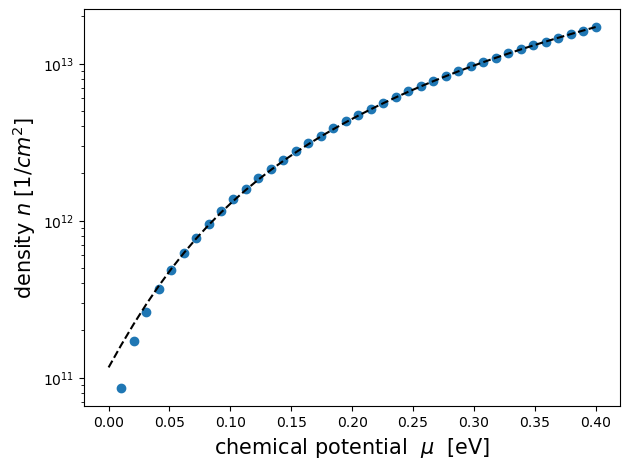

In [6]:
plt.scatter((own_mus[1:] - own_EF), densities[1:]*1e16)

plt.plot((own_mus - own_EF), ana_densities * 1e16, 'k--')

plt.xlabel(r'chemical potential  $\mu$  [eV]', fontsize=15)
plt.ylabel(r'density $n$ [1/$cm^2$]', fontsize=15)

plt.gca().set_yscale('log')
plt.tight_layout()
plt.show()
#plt.savefig(basedir +'../Figures/graphene-density.png')

## Condctivity

We next compare the conductivity as a function of chemical potential, using the in-plane trace of the conductivity tensor, $\sigma = \sigma_{xx} + \sigma_{yy}$. 

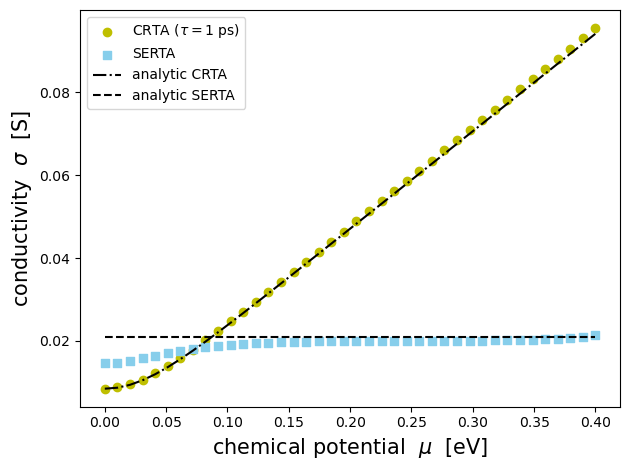

In [7]:
plt.scatter((own_mus - own_EF), (conductivities0[:,0,0]+conductivities0[:,1,1])*(units.qe_SI/1e-20), color="y", label=r'CRTA ($\tau=1$ ps)')
plt.scatter((own_mus - own_EF), (conductivities[:,0,0]+conductivities[:,1,1])*(units.qe_SI/1e-20), color="skyblue", marker='s', label=r'SERTA')

plt.plot((own_mus - own_EF),
            ana_conductivities, 'k-.', label='analytic CRTA')
plt.plot((own_mus - own_EF),
            ana_conductivities_tau, 'k--', label='analytic SERTA')

plt.xlabel(r'chemical potential  $\mu$  [eV]', fontsize=15)
plt.ylabel(r'conductivity  $\sigma$  [S]', fontsize=15)

plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig(basedir +'../Figures/graphene-chempot_conductivity.png')

The scatter plots show the numerical DFTBephy results read from the output for both CRTA (`conductivities0`) and SERTA (`conductivities`), while the dashed/dash–dotted curves show the corresponding values obtained from numerically integrating the analytic expressions.

## Mobility

The mobility is obtained from the ratio of the in-plane conductivity trace to the density $n$ via $\mu = (\sigma_{xx} + \sigma_{yy})/(e n)$, where $e$ is the elementary charge.

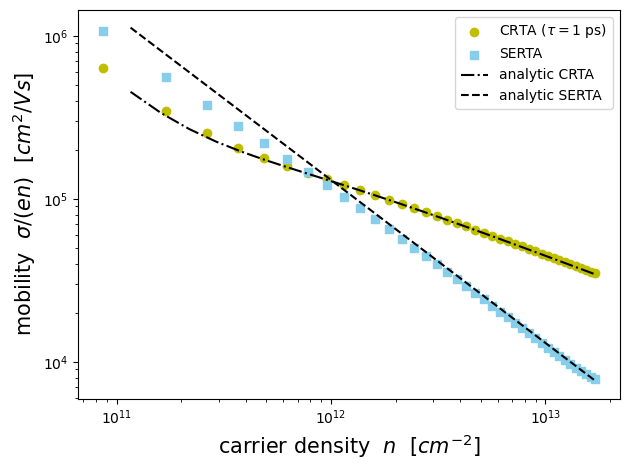

In [8]:
plt.scatter(densities[1:]* 1e16, 1e4*(conductivities0[1:,0,0]+conductivities0[1:,1,1])/densities[1:], color="y", label=r'CRTA ($\tau=1$ ps)')
plt.scatter(densities[1:]* 1e16, 1e4*(conductivities[1:,0,0]+conductivities[1:,1,1])/densities[1:], color="skyblue", label=r'SERTA', marker='s')

plt.plot(ana_densities * 1e16, 
            1e4* 1e-8 *ana_conductivities / (ElementaryCharge*ana_densities), 'k-.', label='analytic CRTA')
plt.plot(ana_densities * 1e16, 
            1e4* 1e-8 *ana_conductivities_tau / (ElementaryCharge*ana_densities), 'k--', label='analytic SERTA')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel(r'carrier density  $n$  [$cm^{-2}$]', fontsize=15)
plt.ylabel(r'mobility  $\sigma/(e n)$  [$cm^{2}/V s$]', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig(basedir +'../Figures/graphene-density_mobility.png')